In [1]:
import torch
import torch.nn as nn
from torch import Tensor
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

class Flow(nn.Module):
    """
    Simple flow model that takes in input tensor and time and outputs transformed tensor.
    Consists of 4 linear layers with ELU activations
    """
    def __init__(self, dim: int = 1, h: int = 64): 
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim + 1, h), nn.ELU(),
            nn.Linear(h, h), nn.ELU(),
            nn.Linear(h, h), nn.ELU(),
            nn.Linear(h, dim))
    
    def forward(self, t: Tensor, x_t: Tensor) -> Tensor:
        return self.net(torch.cat((t, x_t), -1))
    
    def step(self, x_t: Tensor, t_start: Tensor, t_end: Tensor) -> Tensor:
        """
        Calculate the probability density at a particular time step
        """
        # Reshape t_start to be a column vector and expand to match the batch size of x_t
        t_start = t_start.view(1, 1).expand(x_t.shape[0], 1)

        # Translate x_t by the expected midpoint velocity between t_start and t_end
        start_vel = self.forward(x_t=x_t, t=t_start)
        midpoint_x = x_t + (start_vel * (t_end - t_start) / 2)
        midpoint_vel = self.forward(x_t=midpoint_x, t=t_start + (t_end - t_start) / 2)

        return x_t + (t_end - t_start) * midpoint_vel

## 1-D Gaussian + Gaussian Target Distribution

<Axes: ylabel='Density'>

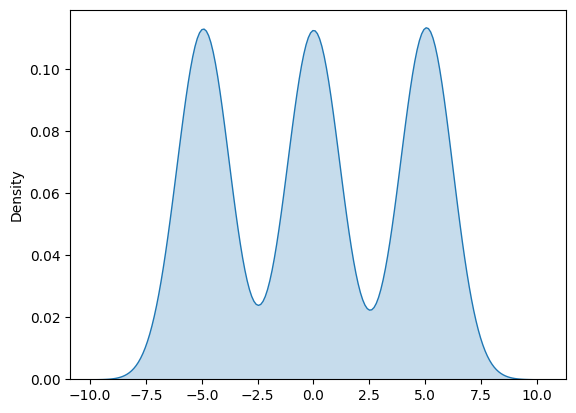

In [2]:
flow_model = Flow(dim=1, h=256)
optimizer = torch.optim.Adam(flow_model.parameters(), 1e-2)
loss_fn = nn.MSELoss()

num_samples = 2048

# Target 1D gaussians
means = [-5.0, 0.0, 5.0]
stds = [0.75, 0.75, 0.75]

samples1 = np.random.normal(loc=means[0], scale=stds[0], size=num_samples // 3)
samples2 = np.random.normal(loc=means[1], scale=stds[1], size=num_samples // 3)
samples3 = np.random.normal(loc=means[2], scale=stds[2], size=num_samples // 3)
x_1_np = np.concatenate((samples1, samples2, samples3)).reshape(-1, 1) 
x_1 = Tensor(x_1_np)
sns.kdeplot(x_1_np.flatten(), fill=True)

In [3]:
x_0_dist_mean = torch.tensor([0.0])
x_0_dist_std = torch.tensor([1.5])
num_epochs = 20000
losses = []
for epoch in range(num_epochs):
    x_0 = torch.randn(len(x_1), 1) * x_0_dist_std + x_0_dist_mean
    t = torch.rand(len(x_1), 1)
    x_t = (1 - t) * x_0 + t * x_1
    dx_t = x_1 - x_0
    optimizer.zero_grad()
    loss = loss_fn(flow_model(t=t, x_t=x_t), dx_t)
    losses.append(loss.item())
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 1000 == 0:
        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {loss.item():.4f}")

print("Training complete.")

Epoch 1000/20000, Loss: 8.7698
Epoch 2000/20000, Loss: 8.7677
Epoch 3000/20000, Loss: 8.7183
Epoch 4000/20000, Loss: 8.8783
Epoch 5000/20000, Loss: 9.0450
Epoch 6000/20000, Loss: 8.9681
Epoch 7000/20000, Loss: 9.0052
Epoch 8000/20000, Loss: 8.5322
Epoch 9000/20000, Loss: 8.8927
Epoch 10000/20000, Loss: 8.9317
Epoch 11000/20000, Loss: 8.8857
Epoch 12000/20000, Loss: 8.6264
Epoch 13000/20000, Loss: 9.0638
Epoch 14000/20000, Loss: 9.0838
Epoch 15000/20000, Loss: 8.5839
Epoch 16000/20000, Loss: 8.8587
Epoch 17000/20000, Loss: 8.6088
Epoch 18000/20000, Loss: 8.9135
Epoch 19000/20000, Loss: 9.3262
Epoch 20000/20000, Loss: 8.9701
Training complete.


Text(0.5, 1.0, 'Training loss')

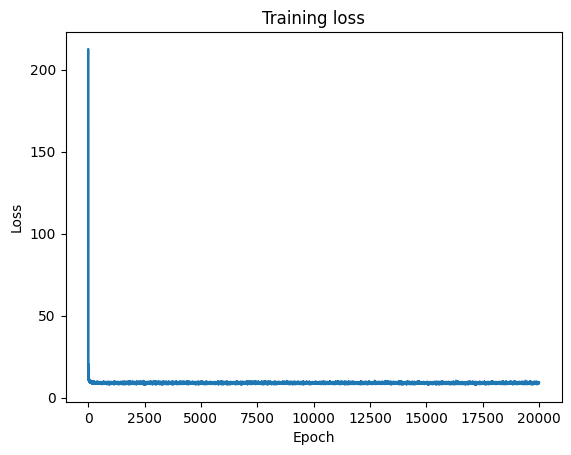

In [4]:
sns.lineplot(x=range(len(losses)), y=losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training loss")

In [5]:
def simulate_trajectory(flow_model: Flow, x_start: Tensor, t_start: float, t_end: float, num_steps: int = 50) -> Tensor:
    dt = (t_end - t_start) / num_steps
    x_current = x_start.clone().detach()
    
    for i in range(num_steps):
        t_current = t_start + i * dt
        t_next = t_current + dt
        x_current = flow_model.step(x_current, 
                                  torch.tensor(t_current, dtype=torch.float32), 
                                  torch.tensor(t_next, dtype=torch.float32))
    
    return x_current

In [6]:
from IPython.display import HTML
from scipy.stats import gaussian_kde 
import matplotlib.animation as animation

BANDWIDTH = 0.3

def create_flow_evolution_video(flow_model, initial_gaussian_samples, x_1, simulate_trajectory, save_path):
    flow_model.eval()

    x_min_plot = min(initial_gaussian_samples.min().item(), x_1.min().item()) - 0.5
    x_max_plot = max(initial_gaussian_samples.max().item(), x_1.max().item()) + 0.5
    

    num_time_slices = 100 
    time_points = np.linspace(0, 1, num_time_slices)
    num_x_points = 200
    x_grid = np.linspace(x_min_plot, x_max_plot, num_x_points)
    
    density_matrix = np.zeros((num_time_slices, num_x_points))
    with torch.no_grad():
        for i, t_val in enumerate(time_points):
            if i % 10 == 0:
                print(f"Time step {i+1}/{num_time_slices}")
            if t_val == 0:
                current_x_samples = initial_gaussian_samples.cpu().numpy().flatten()
            else:
                current_x_samples = simulate_trajectory(flow_model, initial_gaussian_samples, 0, t_val, num_steps=50).cpu().numpy().flatten()
            
            kde = gaussian_kde(current_x_samples, bw_method=BANDWIDTH)
            density_matrix[i, :] = kde(x_grid)
    
    max_density = density_matrix.max()
    if max_density > 0:
        density_matrix /= max_density
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    # Left plot
    im = ax1.imshow(np.zeros((num_x_points, 1)), aspect='auto', origin='lower', 
                   cmap='viridis', extent=[0, 0, x_min_plot, x_max_plot],
                   vmin=0, vmax=1)
    
    ax1.set_xlabel('Time (t)')
    ax1.set_ylabel('x')
    ax1.set_title('Density Heatmap')
    plt.colorbar(im, ax=ax1, label='Normalized Probability Density')
    
    # Right plot: Current time step PDF with target reference
    target_kde = gaussian_kde(x_1.cpu().numpy().flatten(), bw_method=BANDWIDTH)
    target_density = target_kde(x_grid)
    target_density /= target_density.max()
    ax2.plot(x_grid, target_density, 'r-', linewidth=2, label='Target (t=1)', alpha=0.7)
    ax2.fill_between(x_grid, target_density, alpha=0.3, color='red')
    
    # Current distribution 
    line_current, = ax2.plot([], [], 'g-', linewidth=3, label='Current')
    ax2.set_xlim(x_min_plot, x_max_plot)
    ax2.set_ylim(0, 1.1)
    ax2.set_xlabel('x')
    ax2.set_ylabel('Normalized Density')
    ax2.set_title('Current vs Target Distribution')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    time_text = ax2.text(0.02, 0.95, '', transform=ax2.transAxes, fontsize=14,
                        bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    def animate(frame):
        current_time_slice = frame + 1
        current_density_matrix = density_matrix[:current_time_slice, :].T
        current_time_extent = time_points[current_time_slice - 1]
        im.set_array(current_density_matrix)
        im.set_extent([0, current_time_extent, x_min_plot, x_max_plot])
        ax1.set_xlim(0, 1.0) 
        current_density = density_matrix[frame, :]
        t_val = time_points[frame]
        
        line_current.set_data(x_grid, current_density)

        for collection in ax2.collections:
            collection.remove()
        ax2.fill_between(x_grid, current_density, alpha=0.5, color='green')

        time_text.set_text(f't = {t_val:.3f}')
        
        return im, line_current, time_text    

    anim = animation.FuncAnimation(fig, animate, frames=num_time_slices, 
                                 interval=100, blit=False, repeat=True)
    
    Writer = animation.writers['ffmpeg']
    writer = Writer(fps=10, metadata=dict(artist='Flow Matching'), bitrate=1800)
    anim.save(save_path, writer=writer)
    plt.close(fig)

    return anim

In [7]:
num_plot_samples = 25000
initial_gaussian_samples = torch.randn(num_plot_samples, 1) * x_0_dist_std + x_0_dist_mean
anim = create_flow_evolution_video(flow_model, initial_gaussian_samples, x_1, simulate_trajectory, save_path='figs/flow_evolution.mp4')
HTML(anim.to_jshtml())
plt.show()

Time step 1/100
Time step 11/100
Time step 21/100
Time step 31/100
Time step 41/100
Time step 51/100
Time step 61/100
Time step 71/100
Time step 81/100
Time step 91/100


/var/folders/nf/5j1mvt3s2xxg28f4qcpqlhx40000gn/T/ipykernel_36637/2154015412.py:39: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  im = ax1.imshow(np.zeros((num_x_points, 1)), aspect='auto', origin='lower',
/var/folders/nf/5j1mvt3s2xxg28f4qcpqlhx40000gn/T/ipykernel_36637/2154015412.py:72: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  im.set_extent([0, current_time_extent, x_min_plot, x_max_plot])


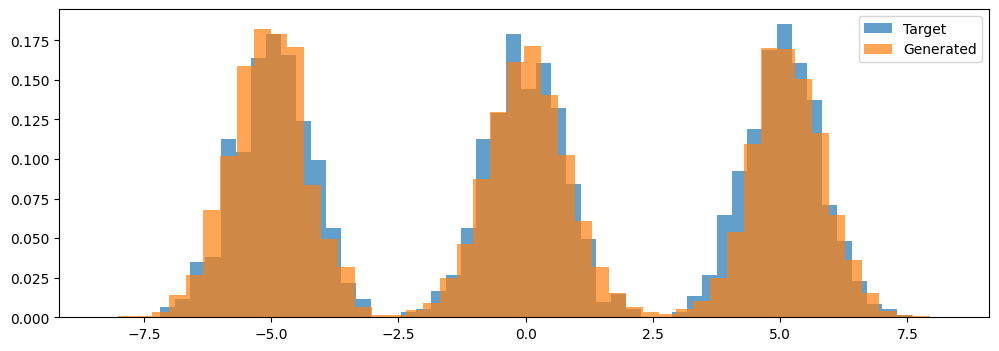

In [8]:
final_samples = simulate_trajectory(flow_model, initial_gaussian_samples, 0, 1.0, num_steps=50)

plt.figure(figsize=(12, 4))
plt.hist(x_1.numpy().flatten(), bins=50, alpha=0.7, density=True, label='Target')
plt.hist(final_samples.detach().numpy().flatten(), bins=50, alpha=0.7, density=True, label='Generated')
plt.legend()
plt.savefig('figs/final_samples_histogram.png')

In [9]:
times = torch.linspace(0, 1, 20)
t = times.view(-1, 1, 1).expand(-1, initial_gaussian_samples.shape[0], 1)  # (num_times, num_samples, 1)
x = initial_gaussian_samples.unsqueeze(0).expand(times.shape[0], -1, -1)   # (num_times, num_samples, 1)
vector_fields = flow_model.forward(t.reshape(-1, 1), x.reshape(-1, x.shape[-1]))
vector_fields = vector_fields.view(times.shape[0], initial_gaussian_samples.shape[0], -1)

## Moon plot

In [10]:
from sklearn.datasets import make_moons
flow = Flow(dim=2)

optimizer = torch.optim.Adam(flow.parameters(), 1e-2)
loss_fn = nn.MSELoss()
x_1 = Tensor(make_moons(256, noise=0.05)[0])

for _ in range(10000):
    x_0 = torch.randn_like(x_1)
    t = torch.rand(len(x_1), 1)
    
    x_t = (1 - t) * x_0 + t * x_1
    dx_t = x_1 - x_0
    
    optimizer.zero_grad()
    loss_fn(flow(t=t, x_t=x_t), dx_t).backward()
    optimizer.step()

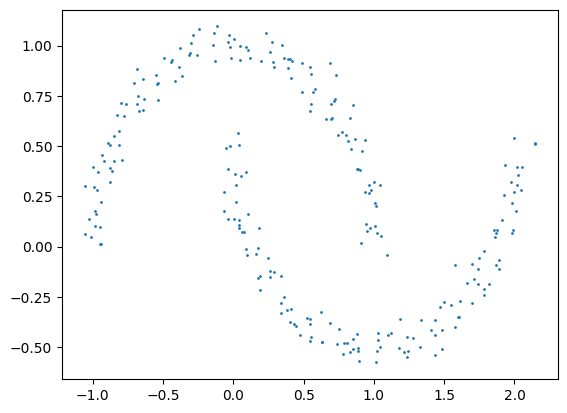

In [11]:
# plot make moons noise=0.05
plt.scatter(x_1[:, 0].detach().numpy(), x_1[:, 1].detach().numpy(), s=1, label='x_1')

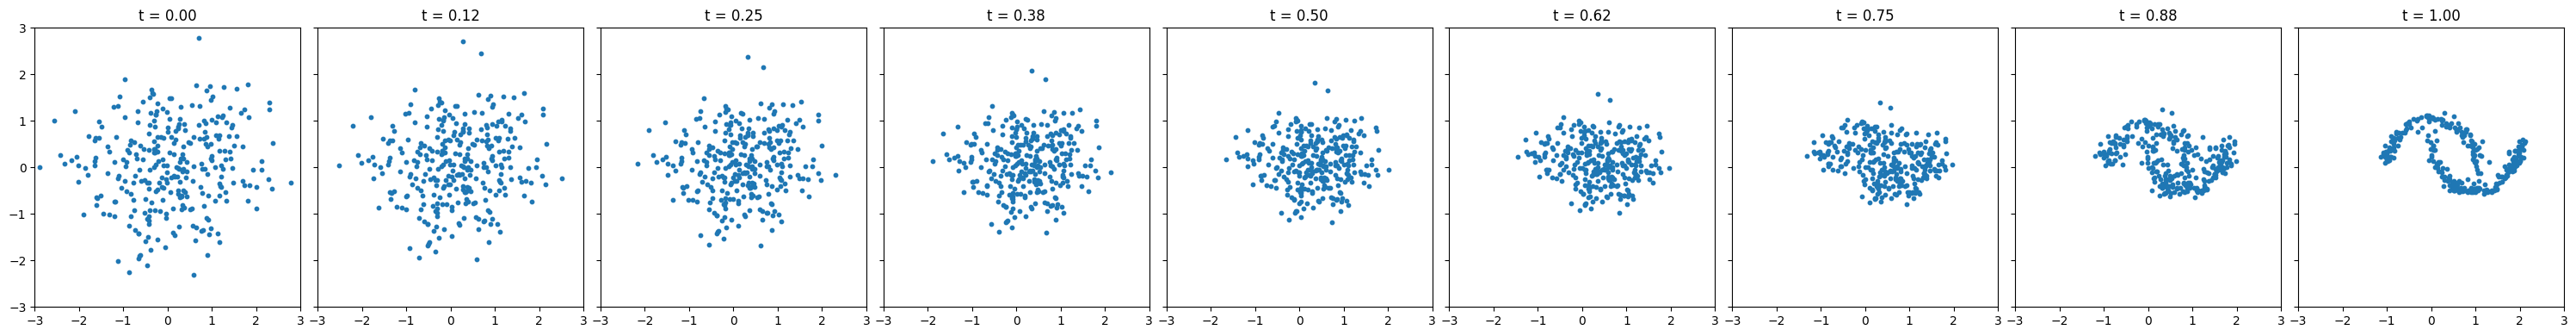

In [12]:
x = torch.randn(300, 2)
n_steps = 8
fig, axes = plt.subplots(1, n_steps + 1, figsize=(30, 4), sharex=True, sharey=True)
time_steps = torch.linspace(0, 1.0, n_steps + 1)

axes[0].scatter(x.detach()[:, 0], x.detach()[:, 1], s=10)
axes[0].set_title(f't = {time_steps[0]:.2f}')
axes[0].set_xlim(-3.0, 3.0)
axes[0].set_ylim(-3.0, 3.0)

for i in range(n_steps):
    x = flow.step(x_t=x, t_start=time_steps[i], t_end=time_steps[i + 1])
    axes[i + 1].scatter(x.detach()[:, 0], x.detach()[:, 1], s=10)
    axes[i + 1].set_title(f't = {time_steps[i + 1]:.2f}')

plt.tight_layout()
plt.show()